In [1]:
# coding : unicode_escape
import pandas as pd
import os
import numpy as np
import datetime
from matplotlib import pyplot as plt
import pickle
import re
import copy
from pypinyin import lazy_pinyin
from DiDiTTI_utils import *
from StrictDataFormat import StrictDataFormat
%matplotlib inline

<font color=#0029CC size=4>This dataset contains Chinese. To display Chinese when using matplotlib, specify `FontProperties` attribute. If you don't have visualization needs, you can also skip following step.</font>

In [2]:
from matplotlib.font_manager import FontProperties
font_path = r"c:\windows\fonts\simsun.ttc" # specify a FontProperties attribute there.
font = FontProperties(fname=font_path,size=15)

<font color=#0029CC size=4>Run this whole ipynb script once to process one dataset, and modify the currently processed `city` by specifying the value of city.</font>

In [3]:
root = os.path.join(os.getcwd(),"DiDiData")
city_list = ['成都市','济南市','海口市','深圳市','苏州市','西安市']
# choose city
city = city_list[5]
print("You are processing `{}` dataset.".format(city))
data_path = os.path.join(root,city)

You are processing `西安市` dataset.


<font color=#0029CC size=4>loading `boundary.txt` and` road.txt`...</font>

In [4]:
boundary = pd.read_csv(os.path.join(data_path,"boundary.txt"),sep='	',encoding='utf-8')
boundary.head()

,obj_id,obj_name,geom
0,10,西安市,"POLYGON((108.37161 33.79388,108.36954 33.79387..."
1,753,蓝田县,"POLYGON((109.44918 33.8387,109.4474 33.83884,1..."
2,754,雁塔区,"POLYGON((108.91066 34.17078,108.91014 34.1708,..."
3,755,临潼区,"POLYGON((109.35936 34.27677,109.35861 34.2769,..."
4,758,莲湖区,"POLYGON((108.9096 34.23905,108.90947 34.23911,..."


In [5]:
road = pd.read_csv(os.path.join(data_path,"{}.txt".format(city)),header=None,names=["obj_id","batch_time","tti","speed"],sep=',',encoding='utf-8')
f = lambda x:x.split()[0]
road['date'] = road[['batch_time']].applymap(f)
print("road shape is ",road.shape)
road.head()

road shape is  (39405961, 5)


,obj_id,batch_time,tti,speed,date
0,263962,2018-01-01 00:00:00,1.05467,41.9732,2018-01-01
1,263598,2018-01-01 00:00:00,1.01951,40.9904,2018-01-01
2,263517,2018-01-01 00:00:00,1.09328,38.4469,2018-01-01
3,263338,2018-01-01 00:00:00,1.17827,37.2568,2018-01-01
4,263964,2018-01-01 00:00:00,1.10266,37.0104,2018-01-01


# We need to count the missing data, and then delete the roads with more missing data.
<font color=#0029CC size=4>`Mins_count` is the total number of valid records, and ` days_count` is the number of days with valid records.</font>

In [6]:
mins_count = []
days_count = []
road_id = []

for ind,tmp in road.groupby('obj_id'):
    mins_count.append(tmp.shape[0])
    days_count.append(len(set(tmp['date'])))
    road_id.append(ind)

In [7]:
mins_count = np.array(mins_count)
days_count = np.array(days_count)

<font color=#0029CC size=4>Following shows the total number of records for each road.</font>

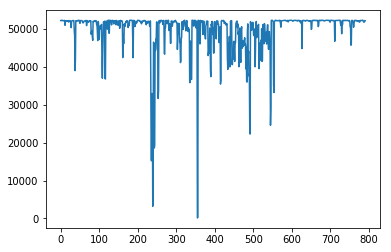

In [8]:
plt.plot(list(range(len(mins_count))),mins_count)

<font color=#0029CC size=4>When the valid record is less than `threshhold`, we delete this road.</font>

In [9]:
threshhold = 40000
ind_A = np.argwhere((mins_count<threshhold)).flatten()
print("total roads number :{} and ".format(len(mins_count))+"{} roads less then {} record.".format(ind_A.shape[0],threshhold))
print(mins_count[ind_A])

total roads number :792 and 38 roads less then 40000 record.
[39020 37019 36989 36807 32643 15372 15227 32979 28046  3224 20209 18590
 19439 31663 33644 35870 35869 36706 36741   143   251 39140 37420 35470
 36321 39340 39475 36171 35986 37612 38310 24442 22271 39551 24599 29533
 35271 33244]


<font color=#0029CC size=4>Following shows the number of days with valid records for each road.</font>

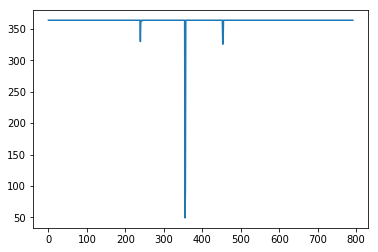

In [10]:
plt.plot(list(range(len(days_count))),days_count)

<font color=#0029CC size=4>When the `threshhold` is less than 335, we delete this road.</font>

In [11]:
threshhold = 335
ind_B = np.argwhere((days_count<threshhold)).flatten()
print("total roads number :{} and ".format(len(days_count))+"{} roads less then {} record".format(ind_B.shape[0],threshhold))
print(days_count[ind_B])

total roads number :792 and 5 roads less then 335 record
[330  49  91 326 326]


In [12]:
# merge ind_A and ind_B
ind_merge = np.unique(np.append(ind_A,ind_B))
print("There are {} roads need to be deleted.".format(ind_merge.shape[0]))
del_id = np.array(road_id)[ind_merge]
print("Their obj_id are: ",del_id)

There are 40 roads need to be deleted.
Their obj_id are:  [263226 263297 263304 263305 263423 263424 263425 263426 263427 263428
 263429 263432 263433 263442 263443 263524 263525 263528 263529 263544
 263545 263578 263579 263604 263605 263623 263642 263643 263670 263672
 263673 263678 263679 263680 263681 263704 263734 263735 263742 263743]


In [13]:
# deleting
drop_tmp = np.array([],dtype=int)
for ind in del_id:
    drop_tmp = np.append(drop_tmp,np.where(road['obj_id']==ind)[0].flatten())
print("road shape before deleting:",road.shape)
road.drop(drop_tmp,inplace = True)
print("road shape after deleting:",road.shape)

road shape before deleting: (39405961, 5)
road shape after deleting: (38182792, 5)


<font color=#0029CC size=4>Update `road_id` after deleting some roads.</font>

In [14]:
# update road_id
tmp = road_id[::]
for index in ind_merge:
    road_id.remove(tmp[index])

<font color=#0029CC size=4>Check the values of `mins_count` and `days_count` and find they both greater than the aforementioned `threshold` .</font>

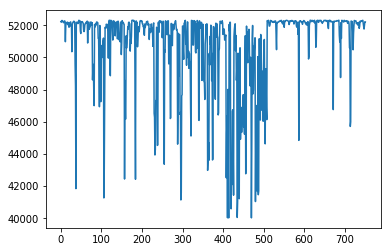

In [15]:
# check mins_count after deleting
count = []
for id,tmp in road.groupby('obj_id'):
    count.append(tmp.shape[0])
count = np.array(count)
plt.plot(list(range(len(count))),count)

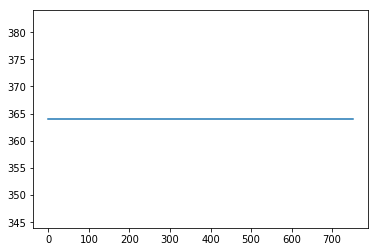

In [16]:
# check days_count after deleting
count = []
for id,tmp in road.groupby('obj_id'):
    count.append(len(set(tmp['date'])))
count = np.array(count)
plt.plot(list(range(len(count))),count)

# Find the time range of current dataset. 
<font color=#0029CC size=4>In fact, the time range of all datasets is `[2018-01-01,2018-12-30]`.</font>

In [17]:
#show start time
RangeSet = []
for id,tmp in road.groupby('obj_id'):
    RangeSet.append((tmp.iloc[0]['date'],tmp.iloc[-1]['date']))

In [18]:
# statistics of time range
pd.Series(RangeSet).value_counts()

(2018-01-01, 2018-12-30)    752
dtype: int64

# Transform data into matrix with shape (8736, len(road_id))
<font color=#0029CC size=4>Note:`8736` is calculated by `24 hours` * `364 days`.</font>

In [19]:
# map function from date to order
date2index = {}
month = {1,3,5,7,8,10}
pattern = "2018-{:0>2}-{:0>2}"
index = 0

for j in range(1,13):
    if j in month:
        i = 31
    elif j==2:
        i = 28
    else:
        i = 30
    for i in range(1,i+1):
        date2index[pattern.format(j,i)] = index
        index += 1
print("This dataset has {} days record.".format(len(date2index)))

minu2index = {}
pattern = "{:0>2}:{:0>2}:00"

index = 0
for hour in range(0,24):
    for minu in range(0,6):
        minu2index[pattern.format(hour,minu*10)] = index
        index += 1
print("Every day has {} valid records.".format(len(minu2index)))

This dataset has 364 days record.
Every day has 144 valid records.


In [20]:
nodeNum = len(road_id)
# Init matrix with shape (52416, len(road_id))
TrafficNode_TTI = np.zeros((len(date2index)*len(minu2index),nodeNum),dtype=np.float32)
print("`{}` dataset has {} roads.".format(city,nodeNum))
print("Matrix shape is {}".format(TrafficNode_TTI.shape))

`西安市` dataset has 752 roads.
Matrix shape is (52416, 752)


In [21]:
def orderById(df,district_id):
    for id in district_id:
        yield id,df[df['obj_id']==id]
def time2index(x):
    time = x.split()
    return date2index[time[0]]*144+minu2index[time[1]]

In [22]:
# map data into TTI matrix
a = orderById(road,road_id)
count = 0
id_order = []
for id,tmp in a:
    #print("index:",index)
    id_order.append(id) #Fix order
    loc = tmp[['batch_time']].applymap(time2index)['batch_time']
    TrafficNode_TTI[[loc],count] = tmp['tti']
    count += 1

<font color=#0029CC size=4>The `TrafficNode_TTI` matrix has many `0` elements, which are actually missing values. We use the data from the previous week or next week to fill it.</font>

In [23]:
#there are many 0 elements in TrafficNode_TTI.
np.argwhere(TrafficNode_TTI==0).flatten()

array([    0,    37,     0, ...,   480, 52415,   587], dtype=int64)

In [24]:
FixMatrix(TrafficNode_TTI)
FixMatrixByDay(TrafficNode_TTI)

In [25]:
# After filling 0 elements, there are no 0 elements.
np.argwhere(TrafficNode_TTI==0).flatten()

array([], dtype=int64)

<font color=#0029CC size=4>The granularity of the original data is 10mins. We change it to one hour.</font>

In [26]:
dimen = TrafficNode_TTI.shape

new_matrix = np.zeros((dimen[0]//6,dimen[1]))
for col in range(dimen[1]):
    for row in range(dimen[0]//6):
        new_matrix[row,col] = np.mean(TrafficNode_TTI[row*6:(row+1)*6,col])
TrafficNode_TTI = new_matrix

<font color=#0029CC size=4>To make the pattern more obvious, take the reciprocal of TTI values.</font>

In [27]:
TrafficNode_TTI = 1./TrafficNode_TTI
TrafficNode_TTI[TrafficNode_TTI>1] = 1

# Randomly select several roads to show TTI characteristics.
<font color=#0029CC size=4>Note:`show_num` is the total number of the selected roads. `show_record_num` is the number of records shown.</font>

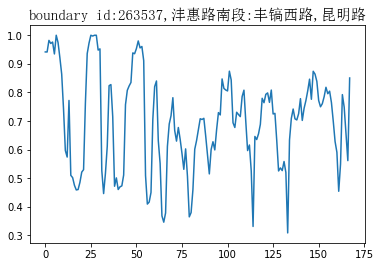

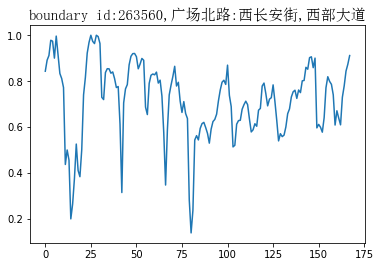

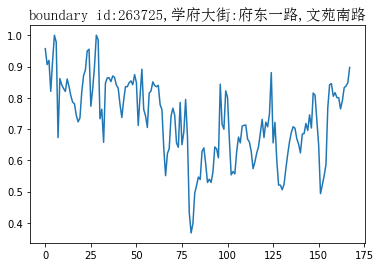

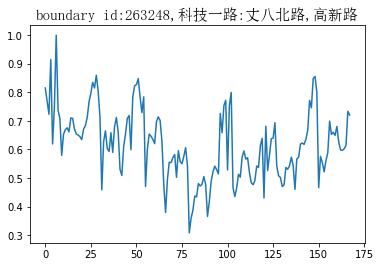

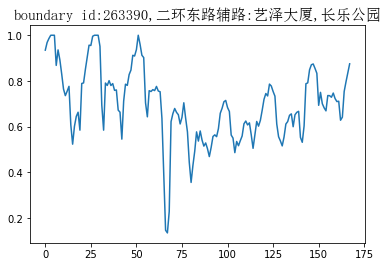

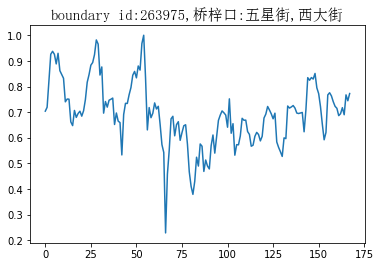

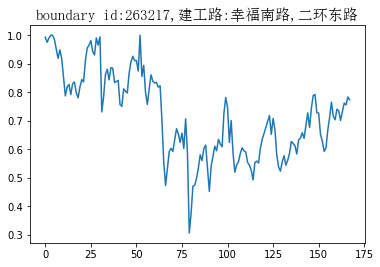

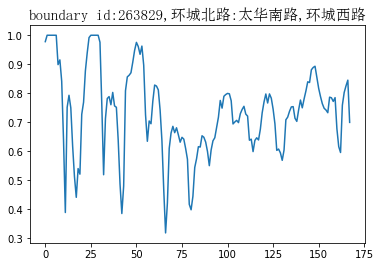

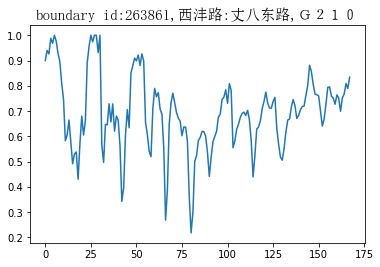

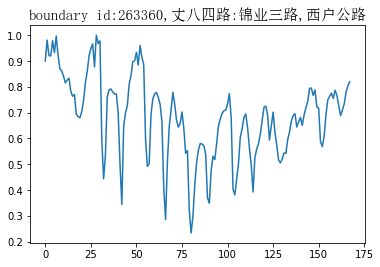

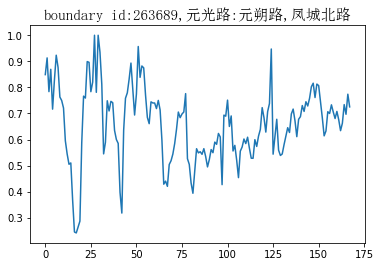

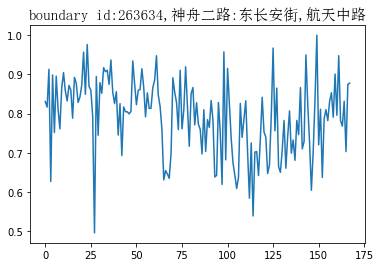

In [28]:
show_num = 12
show_record_num = 24 * 7
x = list(range(0,TrafficNode_TTI[:show_record_num,0].shape[0]))
for index in np.random.randint(0,len(road_id),size=(show_num,)):
    plt.figure()
    plt.plot(x,TrafficNode_TTI[:show_record_num,index])
    #plt.title("boundary id:" + str(id)+','+boundary[boundary['obj_id']==id]['obj_name'].values[0],fontproperties=font)
    plt.title("boundary id:" + str(id_order[index])+','+boundary[boundary['obj_id']==id_order[index]]['obj_name'].values[0],fontproperties=font)

# Extract road location information.
<font color=#0029CC size=4>A road is composed of a series of points(lng,lat). We choose the starting point, the midpoint, and the ending point of the road to represent a road.</font><br>
<font color=#0029CC size=4>The red points in the picture below are the points we selected, and the blue points are all the points on the road.</font>

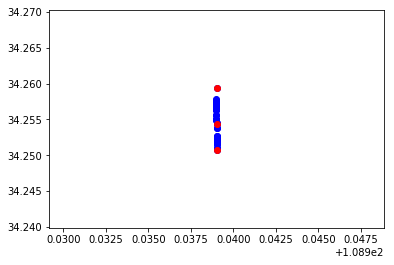

In [29]:
# Randomly select a road and see if the extracted points are appropriate.
show_ind = np.random.randint(0,len(road_id))
extract = str2point(boundary.iloc[show_ind]['geom'])
strinfo = boundary.iloc[show_ind]['geom']
float_pattern = re.compile(r'\d+\.\d+ \d+\.\d+')
tmp = re.findall(float_pattern,strinfo)
point = []
for row in tmp:
    locInfo = row.split()
    point.append((float(locInfo[0]),float(locInfo[1])))

for dot in point:
    plt.scatter(dot[0],dot[1],c='b')

for dot in extract:
    plt.scatter(dot[0],dot[1],c='r')


In [30]:
# start extract station info
StationInfo = []
for index,id in enumerate(road_id):
    tmp = []
    tmp.append(str(index))
    tmp.append(index)
    for point in str2point(boundary.iloc[np.where(boundary['obj_id']==id)].iloc[0,2]):
        tmp.append(point[0])
        tmp.append(point[1])
    tmp.append("obj_id:"+str(id))
    StationInfo.append(tmp)
#print(StationInfo)

# Export data to release_data_dir.
<font color=#0029CC size=4>Note: `StrictDataFormat` is our data format that can be recognized by [dataloader](https://di-chai.github.io/UCTB/UCTB.dataset.html).</font>

In [31]:
release_data_dir = os.path.join(os.getcwd(),"release_data_dir")
tti = copy.deepcopy(StrictDataFormat)
TimeRange = ["2018-01-01","2018-12-30"]
TimeFitness = 60

# tti
tti['TimeRange'] = TimeRange
tti['TimeFitness'] = TimeFitness
tti['Node']['TrafficNode'] = TrafficNode_TTI
tti['Node']['StationInfo'] = StationInfo
delta = (datetime.datetime.strptime(TimeRange[1],"%Y-%m-%d")-datetime.datetime.strptime(TimeRange[0],"%Y-%m-%d")).days+1
print("TTI->>>TrafficNode dimensions should be {}.And it is {}".format((delta*144//6,len(road_id)),tti['Node']['TrafficNode'].shape))
#tti

TTI->>>TrafficNode dimensions should be (8736, 752).And it is (8736, 752)


In [32]:
import pickle
dataset = 'DiDi'
Type = "Road"
value = "TTI"
city_ascii = ("".join(lazy_pinyin(city)[:-1])).capitalize()

with open(os.path.join(release_data_dir, '{}_{}_{}{}.pkl'.format(dataset, city_ascii,Type,value)), 'wb') as f:
    pickle.dump(tti, f)
print("`{}` dataset is Done. You can find it in `release_data_dir`".format(city))

`西安市` dataset is Done. You can find it in `release_data_dir`
